## Evaluate the Match Results, Part A

A lot of poking and prodding of the data.  Does it make sense?

In [2]:
import time, pickle, glob, os
from matching_functions import *

BIBLE_SHINGLE_FOLDER = '/home/spenteco/text_reuse.HOME/bible_pickles/'
EEBO_SHINGLE_FOLDER = '/home/spenteco/0/eebo_shingled/'
RESULTS_FOLDER = '/home/spenteco/0/bible_matches/'
METADATA_FILE = 'metadata/EEBO_metadata.tsv'

metadata = load_metadata(METADATA_FILE)

### Load all the matches . . . 

 . . . so they're easy to access later.
 
 Note that, based on this matching process, it seems that only 40% of the texts quote the Bible.

In [3]:
n_with_none = 0
n_with_some = 0

all_quotation_data = []

for p in glob.glob('/home/spenteco/0/bible_matches/*.pickle'):
        
    tcp_id = p.split('/')[-1].split('.')[0]
    
    if os.stat(p).st_size == 6:
        n_with_none += 1
        all_quotation_data.append([tcp_id, []])
    else:
        n_with_some += 1
    
        f = open(p, 'rb')
        data = pickle.load(f)
        f.close()
        
        all_quotation_data.append([tcp_id, data])
    
print('n_with_none', n_with_none, 
      'n_with_some', n_with_some, 
      'len(all_quotation_data)', len(all_quotation_data))

n_with_none 36370 n_with_some 23962 len(all_quotation_data) 60332


### What a match looks like . . . 

Here, I print out one match.  It's in this format:

    [eeoo_tcp_key, matches_to_bible_verses].
    
So, in this example, it's like

    ['A09675', [['/home/spenteco/text_reuse . . .  ]]
   
where "A09675" is the TCP ID of the file for which I am reporting bible quotation/matching.

"matches_to_bible_verses" is itself a list of matches, since any given text may quote the Bible more than onces.  A match has the format
    
    [source_bible, biblical_reference, biblical_text, match_detals]
    
"match_detals" is in turn a list of

    [matching_bible_text, matching_tcp_text, bible_position, matching_position]
    
For example, the first match:

    ['/home/spenteco/text_reuse.HOME/bible_pickles/KJV_OTA.pickle', 'Psalms.17.14', 'From men which are thy hand, O LORD, from men of the world, which have their portion in this life, and whose belly thou fillest with thy hid treasure: they are full of children, and leave the rest of their substance to their babes.', ['men which are thy hand, O LORD, from men of the world, which have their portion in this life, and whose belly thou fillest with thy hid treasure: they are full of children, and leave the rest of their substance', 'men by thine hand O Lord, from men of the world, who have their portion in this life, whose bellies thou fillest with thine hidde treasures: their children have enough, and leave the rest of their substance', [2, 86], [5502, 5579]]]
    
which say: 1) I've matched to the Oxford Text Archive King James Version; 2) I've matces Psalms 17:14; the fill text of Psalms 17:14 is given; 3) the exact match from KJV_OTA was "men which are thy hand . . . and leave the rest of their substance"; 4) the exact match from A09675 is "men by thine hand O Lord . . . leave the rest of their substance" (note that the two "exact" matches do not exactly match; the allowance for gaps has permitted us to expand these matches outward); 5) and the locations of the matches in the two texts (\[2, 86\], \[5502, 5579\]).

In [3]:
print(all_quotation_data[0])

['A09675', [['/home/spenteco/text_reuse.HOME/bible_pickles/KJV_OTA.pickle', 'Psalms.17.14', 'From men which are thy hand, O LORD, from men of the world, which have their portion in this life, and whose belly thou fillest with thy hid treasure: they are full of children, and leave the rest of their substance to their babes.', ['men which are thy hand, O LORD, from men of the world, which have their portion in this life, and whose belly thou fillest with thy hid treasure: they are full of children, and leave the rest of their substance', 'men by thine hand O Lord, from men of the world, who have their portion in this life, whose bellies thou fillest with thine hidde treasures: their children have enough, and leave the rest of their substance', [2, 86], [5502, 5579]]], ['/home/spenteco/text_reuse.HOME/bible_pickles/KJV_OTA.pickle', 'Psalms.73.2', 'But as for me, my feet were almost gone; my steps had well nigh slipped.', ['feet were almost gone; my steps had well nigh slipped', 'feete wer

## Basic Counting

Here, I'm simply counting how many verses each EEBO-TCP matched to (i.e., how many Bible verses each quotes).

The output is in the form

    ['A10675', 'The Bible and Holy Scriptures conteyned ', 48116, 15304, 14273]
    
The last three numbers (48116, 15304, 14273) are the number of times the text quotes the EEBO-TCP Geneva, the EEBP-TCP KJV, and the OTA KJV.  So, in this example, text A10675 (the EEBO-TCP Geneva) quotes itself 48,116 times (yes, I'm comparing the Geneva with itself), the EEBO-KJV 15,304 times, and the OTA KJV 14,273 times.

I sort and output this data three times, once per Bible, and list only the top 25 texts.  

It's not that surprising that I find a bigger number (48,116) when I compare the EEBO-TCP Geneva to itself than there are verses in the Bible (~33,000). First, because I'm doing the comparison verse-by-verse against the whole text, and second because the Bible repeats itself.  For example, take a common verse like, "And the LORD spake unto Moses, saying".  Suppose that it occurs 100 times in the Geneva.  That means for each of those 100, I'm going to check for a match in the full text, and for each I'm going to find 100 matches.  The result is that just that common verse will add 10,000 to the total number of Geneva-to-Geneva matches.  This is, of course, the extreme example, but it is something to keep in mind.

**A10675** is a Geneva from the 1560's transcribed by the TCP.

**A97378** is a late (1688?) KJV transcribed by the TCP.

**KJV_OTA** is from Oxford Text Archive.

In [5]:
import copy
from collections import defaultdict

quotation_counts = []
source_file_counts_template = {}

for a in all_quotation_data:
    for q in a[1]:
        source_file = q[0].split('/')[-1].split('.')[0]
        source_file_counts_template[source_file] = 0

for a in all_quotation_data:

    m = None
    try:
        m = metadata[a[0]]
    except KeyError:
        pass
    
    if m != None:
        
        source_file_counts = copy.deepcopy(source_file_counts_template)
        
        for q in a[1]:
            source_file = q[0].split('/')[-1].split('.')[0]
            source_file_counts[source_file] += 1
            
        count_results = []
        for k in sorted(source_file_counts.keys()):
            count_results.append(source_file_counts[k])
            
        quotation_counts.append([a[0], 
                                 m['title'][:40]] + 
                                 count_results)
        
print(quotation_counts[0])
print()


count_keys = sorted(source_file_counts_template.keys())
        
print(count_keys)
print()

for a in range(0, len(count_keys)):

    print()
    print('Top 25 texts for ' + count_keys[a] )
    print()

    quotation_counts.sort(key=lambda x: x[a + 2], reverse=True)
    for q in quotation_counts[:25]:
        print('\t', q)

['A09675', 'A sermon, vpon the wordes of Paul the Ap', 30, 17, 18]

['A10675', 'A97378', 'KJV_OTA']


Top 25 texts for A10675

	 ['A10675', 'The Bible and Holy Scriptures conteyned ', 48116, 15304, 14273]
	 ['A97378', 'The Holy Bible containing the Old Testam', 15110, 51217, 43812]
	 ['A10708', 'The. holie. Bible. conteynyng the olde T', 14216, 23911, 23120]
	 ['A10405', 'The Byble in Englyshe that is to saye, t', 8984, 17745, 17526]
	 ['A55368', 'Annotations upon the Holy Bible. Vol. II', 8750, 16409, 16531]
	 ['A10392', 'The most sacred Bible, whiche is the Hol', 8377, 15440, 15065]
	 ['A10349', 'Biblia the Byble, that is, the holy Scry', 6745, 11428, 11092]
	 ['A55363', 'Annotations upon the Holy Bible. Vol. I ', 5538, 29115, 28696]
	 ['A45436', 'A paraphrase and annotations upon all th', 4232, 8421, 8598]
	 ['A26981', 'A paraphrase on the New Testament with n', 4103, 8140, 8251]
	 ['A22507', 'A commentarie vpon the fourth booke of M', 3311, 7917, 8101]
	 ['A68940', 'The Newe Testam

### Number of texts vs number of quotations

How many texts never quote the Bible?  How many quote it just once?  Twice?

Here, I plot only texts which quote between zero and 50 verses; the plots are severely truncated on the x axis.

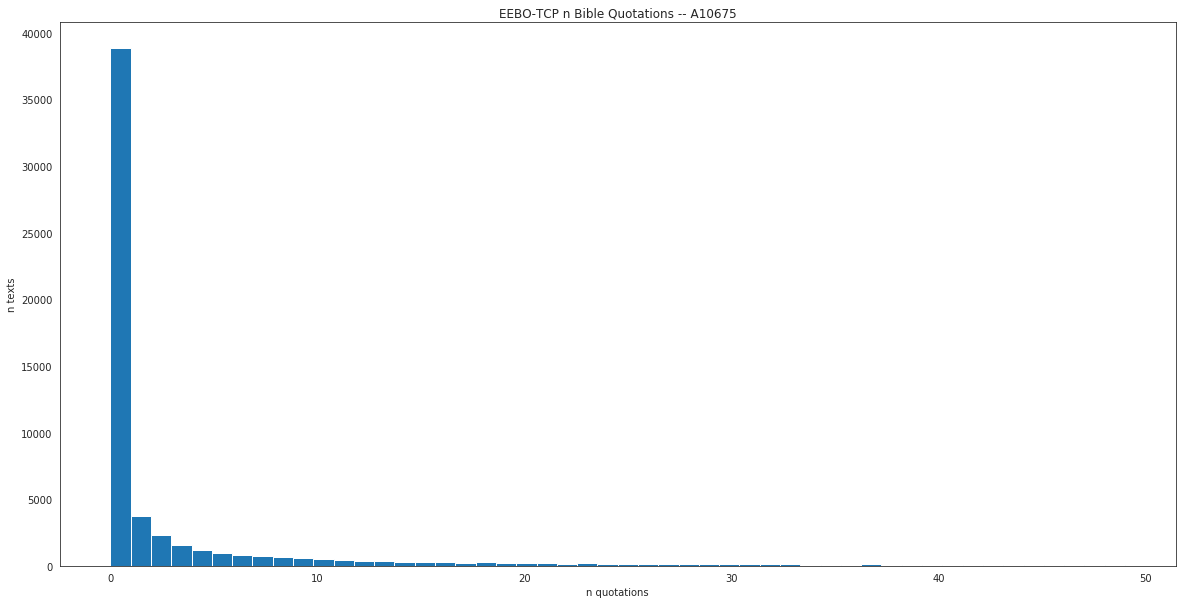

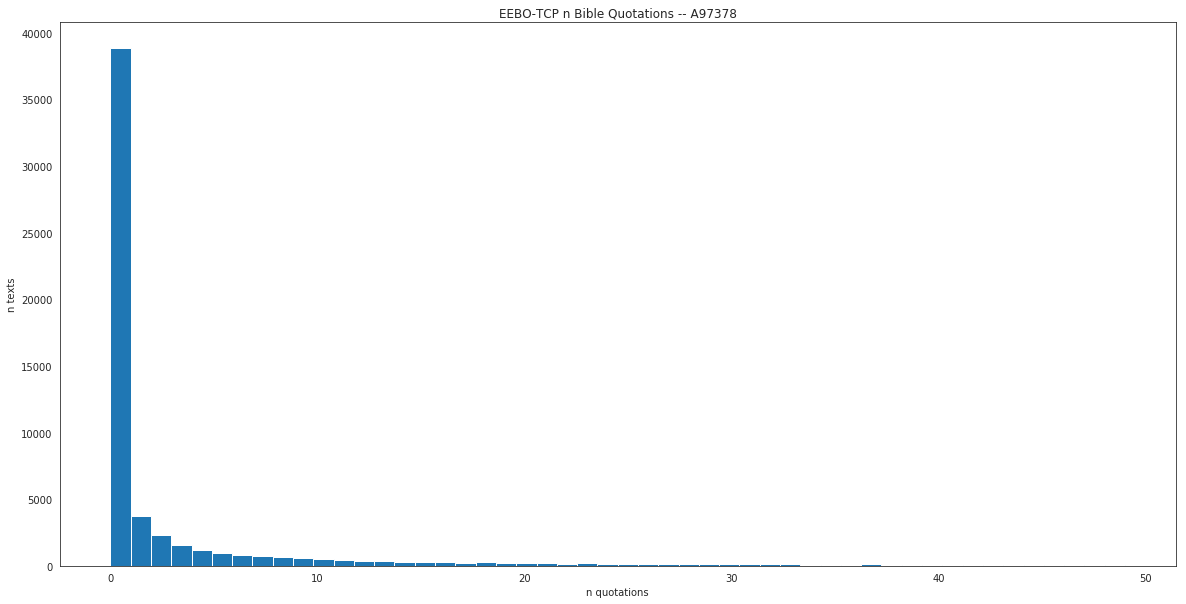

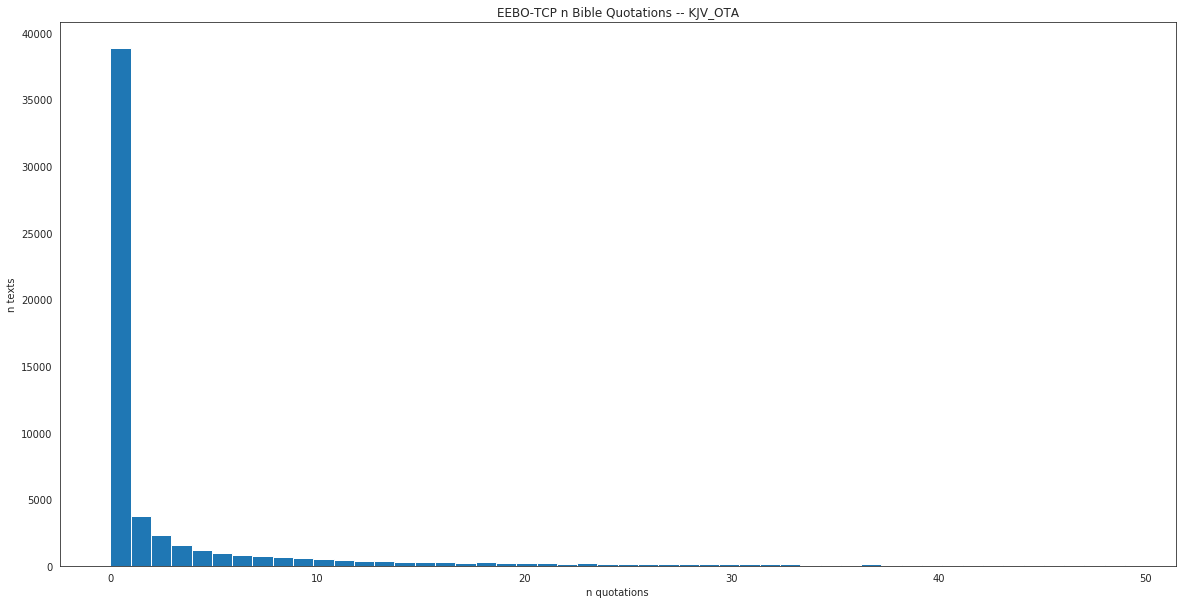

In [5]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

def graph_n_quotations(index, label, upper_limit):

    n_quotations = []

    for q in quotation_counts:
        if q[index] < upper_limit:
            n_quotations.append(q[index])
        
    sns.set_style("white")

    plt.figure(figsize=(20, 10))
    plt.title('EEBO-TCP n Bible Quotations -- ' + label)
    plt.ylabel('n texts')
    plt.xlabel('n quotations')

    plt.hist(n_quotations, bins=50)
    
# ---------------------------------------------------------------------

for tcp_id in count_keys:
    graph_n_quotations(2, tcp_id, 50)

### My Naming and Labeling of Things . . . 

 . . . fails me here more conspicuously that it usually does.
 
 I'm interested in which verses are more or less quoted.  One verse may be quoted by 1,000 texts; another by 10, a third by 1.  What does the spread look like?  The average?  What is never quoted?  What is quoted more often than seems possible?
 
 I do all three Bibles separately, in case the results are different.

In [7]:
import statistics
from collections import defaultdict, Counter

verse_counts = defaultdict(lambda: defaultdict(int))

for a in all_quotation_data:
    
    for q in a[1]:
        source_file = q[0].split('/')[-1].split('.')[0]
        verse_counts[source_file][q[1]] += 1
    
# ------------------------------------------------------------------
            
verse_references = {}
verse_text = {}

for tcp_id in count_keys:
    
    verse_references[tcp_id] = []
    verse_text[tcp_id] = []
    
    for v in load_pickle_file(BIBLE_SHINGLE_FOLDER + tcp_id + '.pickle'):
        verse_references[tcp_id].append(v['reference'])
        verse_text[tcp_id].append(''.join(v['tokens']))
    
# ------------------------------------------------------------------

all_way_overquoted_verses = []

for tcp_id in count_keys:
    
    print('---------------------------------------------------------')
    print(tcp_id)
    print('---------------------------------------------------------')
    
    n_quotations = []

    for r in verse_references[tcp_id]:
        n_quotations.append(verse_counts[tcp_id][r])
    
    print('HOW TEXTS QUOTE ANY GIVEN VERSE? (basic descriptive stats)')
    print()

    print('\t', 'min', min(n_quotations))
    print('\t', 'max', max(n_quotations))
    print('\t', 'mean', statistics.mean(n_quotations))
    print('\t', 'median', statistics.median(n_quotations))
    print('\t', 'mode', statistics.mode(n_quotations))
    print()

    n_never_quoted = 0
    for rn, r in enumerate(verse_references[tcp_id]):
        if verse_counts[tcp_id][r] == 0:
            n_never_quoted += 1
    
    print('n VERSES NEVER QUOTED', n_never_quoted)
    
    n_way_quoted = 0
    for rn, r in enumerate(verse_references[tcp_id]):
        if verse_counts[tcp_id][r] > 1000:
            n_way_quoted += 1
            
            all_way_overquoted_verses.append(r)
    
    print('n VERSES WAY OVERQUOTED', n_way_quoted)
    print()

    print('VERSES NEVER QUOTED?')
    print()
    for rn, r in enumerate(verse_references[tcp_id]):
        if verse_counts[tcp_id][r] == 0:
            print('\t', r, verse_text[tcp_id][rn])
    print()

    print('VERSES WAY OVERQUOTED?')
    print()
    for rn, r in enumerate(verse_references[tcp_id]):
        if verse_counts[tcp_id][r] > 1000:
            print('\t', r, verse_counts[tcp_id][r], verse_text[tcp_id][rn])
    print()


---------------------------------------------------------
A10675
---------------------------------------------------------
HOW TEXTS QUOTE ANY GIVEN VERSE? (basic descriptive stats)

	 min 0
	 max 3593
	 mean 20.423591252008606
	 median 4
	 mode 1

n VERSES NEVER QUOTED 88
n VERSES WAY OVERQUOTED 61

VERSES NEVER QUOTED?

	 Leviticus.11.15 15 And all ravens after their kinde:
	 Numbers.33.32 32 And they removed from Bene-iaakan, & lay in Hor-hagidgad.
	 Numbers.33.46 46 And theiremoved from Dibón-gad, and lay in Almón-diblathaim.
	 Deuteronomy.3.29 29 So we abode in the valley over agaynste Beth-Peôr.
	 Joshua.13.20 20 And Beth-peor, and * Ashdoth pisgáh, & Beth-ieshimoth:
	 Joshua.15.28 28 And Hasar-shuál, and Beershéba, and Biziothiáh,
	 Joshua.15.37 37 Zenám, and Hadasháh, and Migdal-gád,
	 Joshua.15.39 39 Lachish, and Bozkáth, and Eglon. 
	 Joshua.15.49 49 And Dannah, and Kiriath-sannath, [which is Debir]
	 Joshua.15.53 53 And janum, and Beth-tappuah, and Aphekah.
	 Joshua.15.58 58

	 Titus.2.12 1061 12 Teaching us, that denying ungodliness and wordly lusts, we should live soberly, righteously, and godly in this present world;
	 Hebrews.12.29 1409 29 For our God is a consuming fire.
	 Revelation.22.21 2151 21 The grace of our Lord Jesus Christ be with you all. Amen.

---------------------------------------------------------
KJV_OTA
---------------------------------------------------------
HOW TEXTS QUOTE ANY GIVEN VERSE? (basic descriptive stats)

	 min 0
	 max 3593
	 mean 41.43071185132789
	 median 14.0
	 mode 4

n VERSES NEVER QUOTED 284
n VERSES WAY OVERQUOTED 141

VERSES NEVER QUOTED?

	 Genesis.12.16 And he entreated Abram well for her sake: and he had sheep, and oxen, and he asses, and menservants, and maidservants, and she asses, and camels.
	 Genesis.19.37 And the first born bare a son, and called his name Moab: the same is the father of the Moabites unto this day.
	 Genesis.21.32 Thus they made a covenant at Beersheba: then Abimelech rose up, and Phichol 

### Collect the "never quoted" verses . . . 

. . . in one list.

In [10]:
all_way_overquoted_verses = sorted(list(set(all_way_overquoted_verses)))

In [11]:
import textwrap

print('\n'.join(textwrap.wrap(str(all_way_overquoted_verses), 80)))

['1 Corinthians.16.23', '1 Corinthians.3.23', '1 Kings (3 Kings).17.2', '1 Kings
(3 Kings).17.8', '1 Kings.17.2', '1 Kings.17.8', '1 Thessalonians.5.28',
'1_Corinthians.16.23', '1_Corinthians.3.23', '1_Kings.17.2', '1_Kings.17.8',
'1_Thessalonians.5.28', '2 Esdras.1.4', '2 Thessolonians.3.18',
'2_Thessalonians.3.18', 'Acts of the Apostles.13.30', 'Acts.13.30',
'Colossians.3.3', 'Deuteronomy.5.17', 'Ephesians.4.23', 'Ephesians.4.3',
'Ephesians.4.5', 'Ephesians.4.6', 'Exodus.13.1', 'Exodus.14.1', 'Exodus.16.11',
'Exodus.20.13', 'Exodus.20.14', 'Exodus.20.15', 'Exodus.20.3', 'Exodus.25.1',
'Exodus.30.11', 'Exodus.30.17', 'Exodus.31.1', 'Exodus.31.12', 'Exodus.40.1',
'Exodus.6.10', 'Ezechiel.11.14', 'Ezechiel.12.21', 'Ezechiel.13.1',
'Ezechiel.14.2', 'Ezechiel.15.1', 'Ezechiel.16.1', 'Ezechiel.17.1',
'Ezechiel.18.1', 'Ezechiel.21.1', 'Ezechiel.21.18', 'Ezechiel.21.8',
'Ezechiel.22.17', 'Ezechiel.22.23', 'Ezechiel.23.1', 'Ezechiel.25.1',
'Ezechiel.27.1', 'Ezechiel.28.1', 'Ezechiel.28.20', '